<a href="https://colab.research.google.com/github/yiruchen1993/nvidia_gtc_dli_rapids_2020/blob/section_notebooks%2Fmachine_learning/2_08_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost

在此notebook中，您將使用GPU加速gradient boosting來預測給定個體感染模擬病毒的可能性。

## 目標

在您完成本notebook時，您將能夠：

-使用GPU加速的XGBoost

## 載入

我們將使用[XGBoost](https://xgboost.readthedocs.io/en/latest/)建立此練習的gradient boosted模型。

除了常規的RAPIDS組件之外，我們還載入了一些套件，這些套件將在訓練後幫助我們理解和評估XGBoost模型。

In [ ]:
import cudf
import cuml
import cupy as cp

from cuml.preprocessing.model_selection import train_test_split

# visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import graphviz

# model analysis
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import xgboost as xgb

# xgboost version 1.0 or later is required to directly convert from cudf Dataframes to xgboost DMatrix format
print('XGBoost version: ', xgb.__version__)

XGBoost version:  1.0.0-SNAPSHOT


## 載入資料

對於此notebook，我們載入總體數據的子集合，包括之前用於羅吉斯回歸的列和坐標欄位。XGBoost允許我們使用與感興趣的結果具有非線性關係的數據，而地理空間數據通常屬於該類別。

In [ ]:
gdf = cudf.read_csv('./data/pop_2-08.csv', usecols=['age', 'sex', 'northing', 'easting', 'infected'])

In [ ]:
gdf.dtypes

age         float64
sex         float64
northing    float64
easting     float64
infected    float64
dtype: object

In [ ]:
gdf.shape

(58479894, 5)

In [ ]:
gdf.head()

,age,sex,northing,easting,infected
0,0.0,0.0,515491.5313,430772.1875,0.0
1,0.0,0.0,503572.4688,434685.8750,0.0
2,0.0,0.0,517903.6563,432565.5313,0.0
3,0.0,0.0,517059.9063,427660.6250,0.0
4,0.0,0.0,509228.6875,425527.7813,0.0


在分割數據進行訓練和測試之前，我們會檢查記憶體狀態。我們希望將活動GPU的記憶體使用量降低到一半以下，以便拆分後臨時增加的記憶體用量需求仍然足夠。

In [ ]:
!nvidia-smi

Wed Oct  7 08:51:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000E48:00:00.0 Off |                    0 |
| N/A   29C    P0    35W / 250W |   3023MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 0000AF1A:00:00.0 Off |                    0 |
| N/A   28C    P0    25W / 250W |     12MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## 訓練-測試 切割

我們再次使用分割方法來創建訓練和測試數據子集，請記住，這樣做將使用額外的記憶體。

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(gdf[['age', 'sex', 'northing', 'easting']], gdf['infected'])

In [ ]:
!nvidia-smi

Wed Oct  7 08:51:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000E48:00:00.0 Off |                    0 |
| N/A   30C    P0    40W / 250W |   6873MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 0000AF1A:00:00.0 Off |                    0 |
| N/A   27C    P0    25W / 250W |     12MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

現在我們有了訓練和測試的子集，我們可以刪除原始數據，以便為算法的記憶體需求留出空間-在這種情況下並不重要，但是在嘗試訓練盡可能多的數據時是一種有用的做法。

In [ ]:
del(gdf)

## 設定 XGBoost 參數

現在，我們可以為此XGBoost訓練運行設置參數。這些將確定要建立的樹的類型和大小，以及我們衡量成功的方式。

`gpu_hist`樹方法是一個關鍵參數：它告訴XGBoost我們希望訓練在GPU上運行。

對於我們的案例，我們再次要預測個人感染病毒的可能性，因此我們設置了`binary：logistic`目標（二進制結果，使用logistic方法獲得機率）。

其他參數選項和含義可以在[XGBoost參數](https://xgboost.readthedocs.io/en/latest/parameter.html)中找到。

In [ ]:
params = {
    'max_depth':    8,
    'max_leaves':   2**8,
    'tree_method':  'gpu_hist',
    'objective':    'binary:logistic',
    'grow_policy':  'lossguide',
    'eval_metric':  'logloss',
    'subsample':    '0.8'
}

## 訓練模型

XGBoost使用稱為DMatrix的特殊高效能數據結構，因此我們將訓練dataframes傳遞到其中以建立一個。

請注意，數據保留在GPU上，直接從cuDF傳遞到XGBoost。

In [ ]:
dtrain = xgb.DMatrix(x_train, y_train)

現在我們可以開始訓練模型。

In [ ]:
%time model = xgb.train(params, dtrain, num_boost_round=100)

CPU times: user 5.66 s, sys: 4.21 s, total: 9.86 s
Wall time: 9.89 s


In [ ]:
x_train.shape

(43859920, 4)

## 檢查模型

我們可以通過幾種方式檢查模型。 首先，我們可以看到模型認為哪些特徵在評估中最重要。 F分數越高，表明重要性越高。

感染分佈似乎具有很強的地理空間成分，因為easting和northing欄位的F值最高。此外，在確定感染率方面，年齡似乎比性別有更大的影響(與我們從邏輯回歸分析中得到的結果一致)。

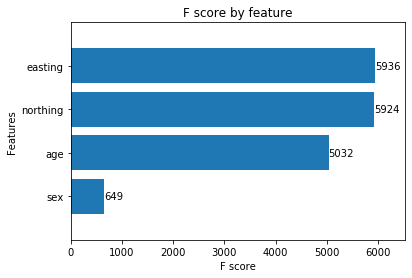

In [ ]:
ax = xgb.plot_importance(model, height=.8)
ax.grid(False)
ax.set_title('F score by feature')
plt.show()

我們還可以提取模型中的單個樹，並準確查看它為ensemble做出的貢獻所使用的決策。注意，與所有ensemble方法一樣，單個樹可能不會在結果（葉節點上的值）上產生主要差異；將通常情況較弱的樹ensemble為一個強大的模型，使XGBoost擁有強大的功能。

嘗試更改`num_trees`以檢查模型中的不同樹。將`rankdir`更改為`TB`將使樹從上到下重新定向。

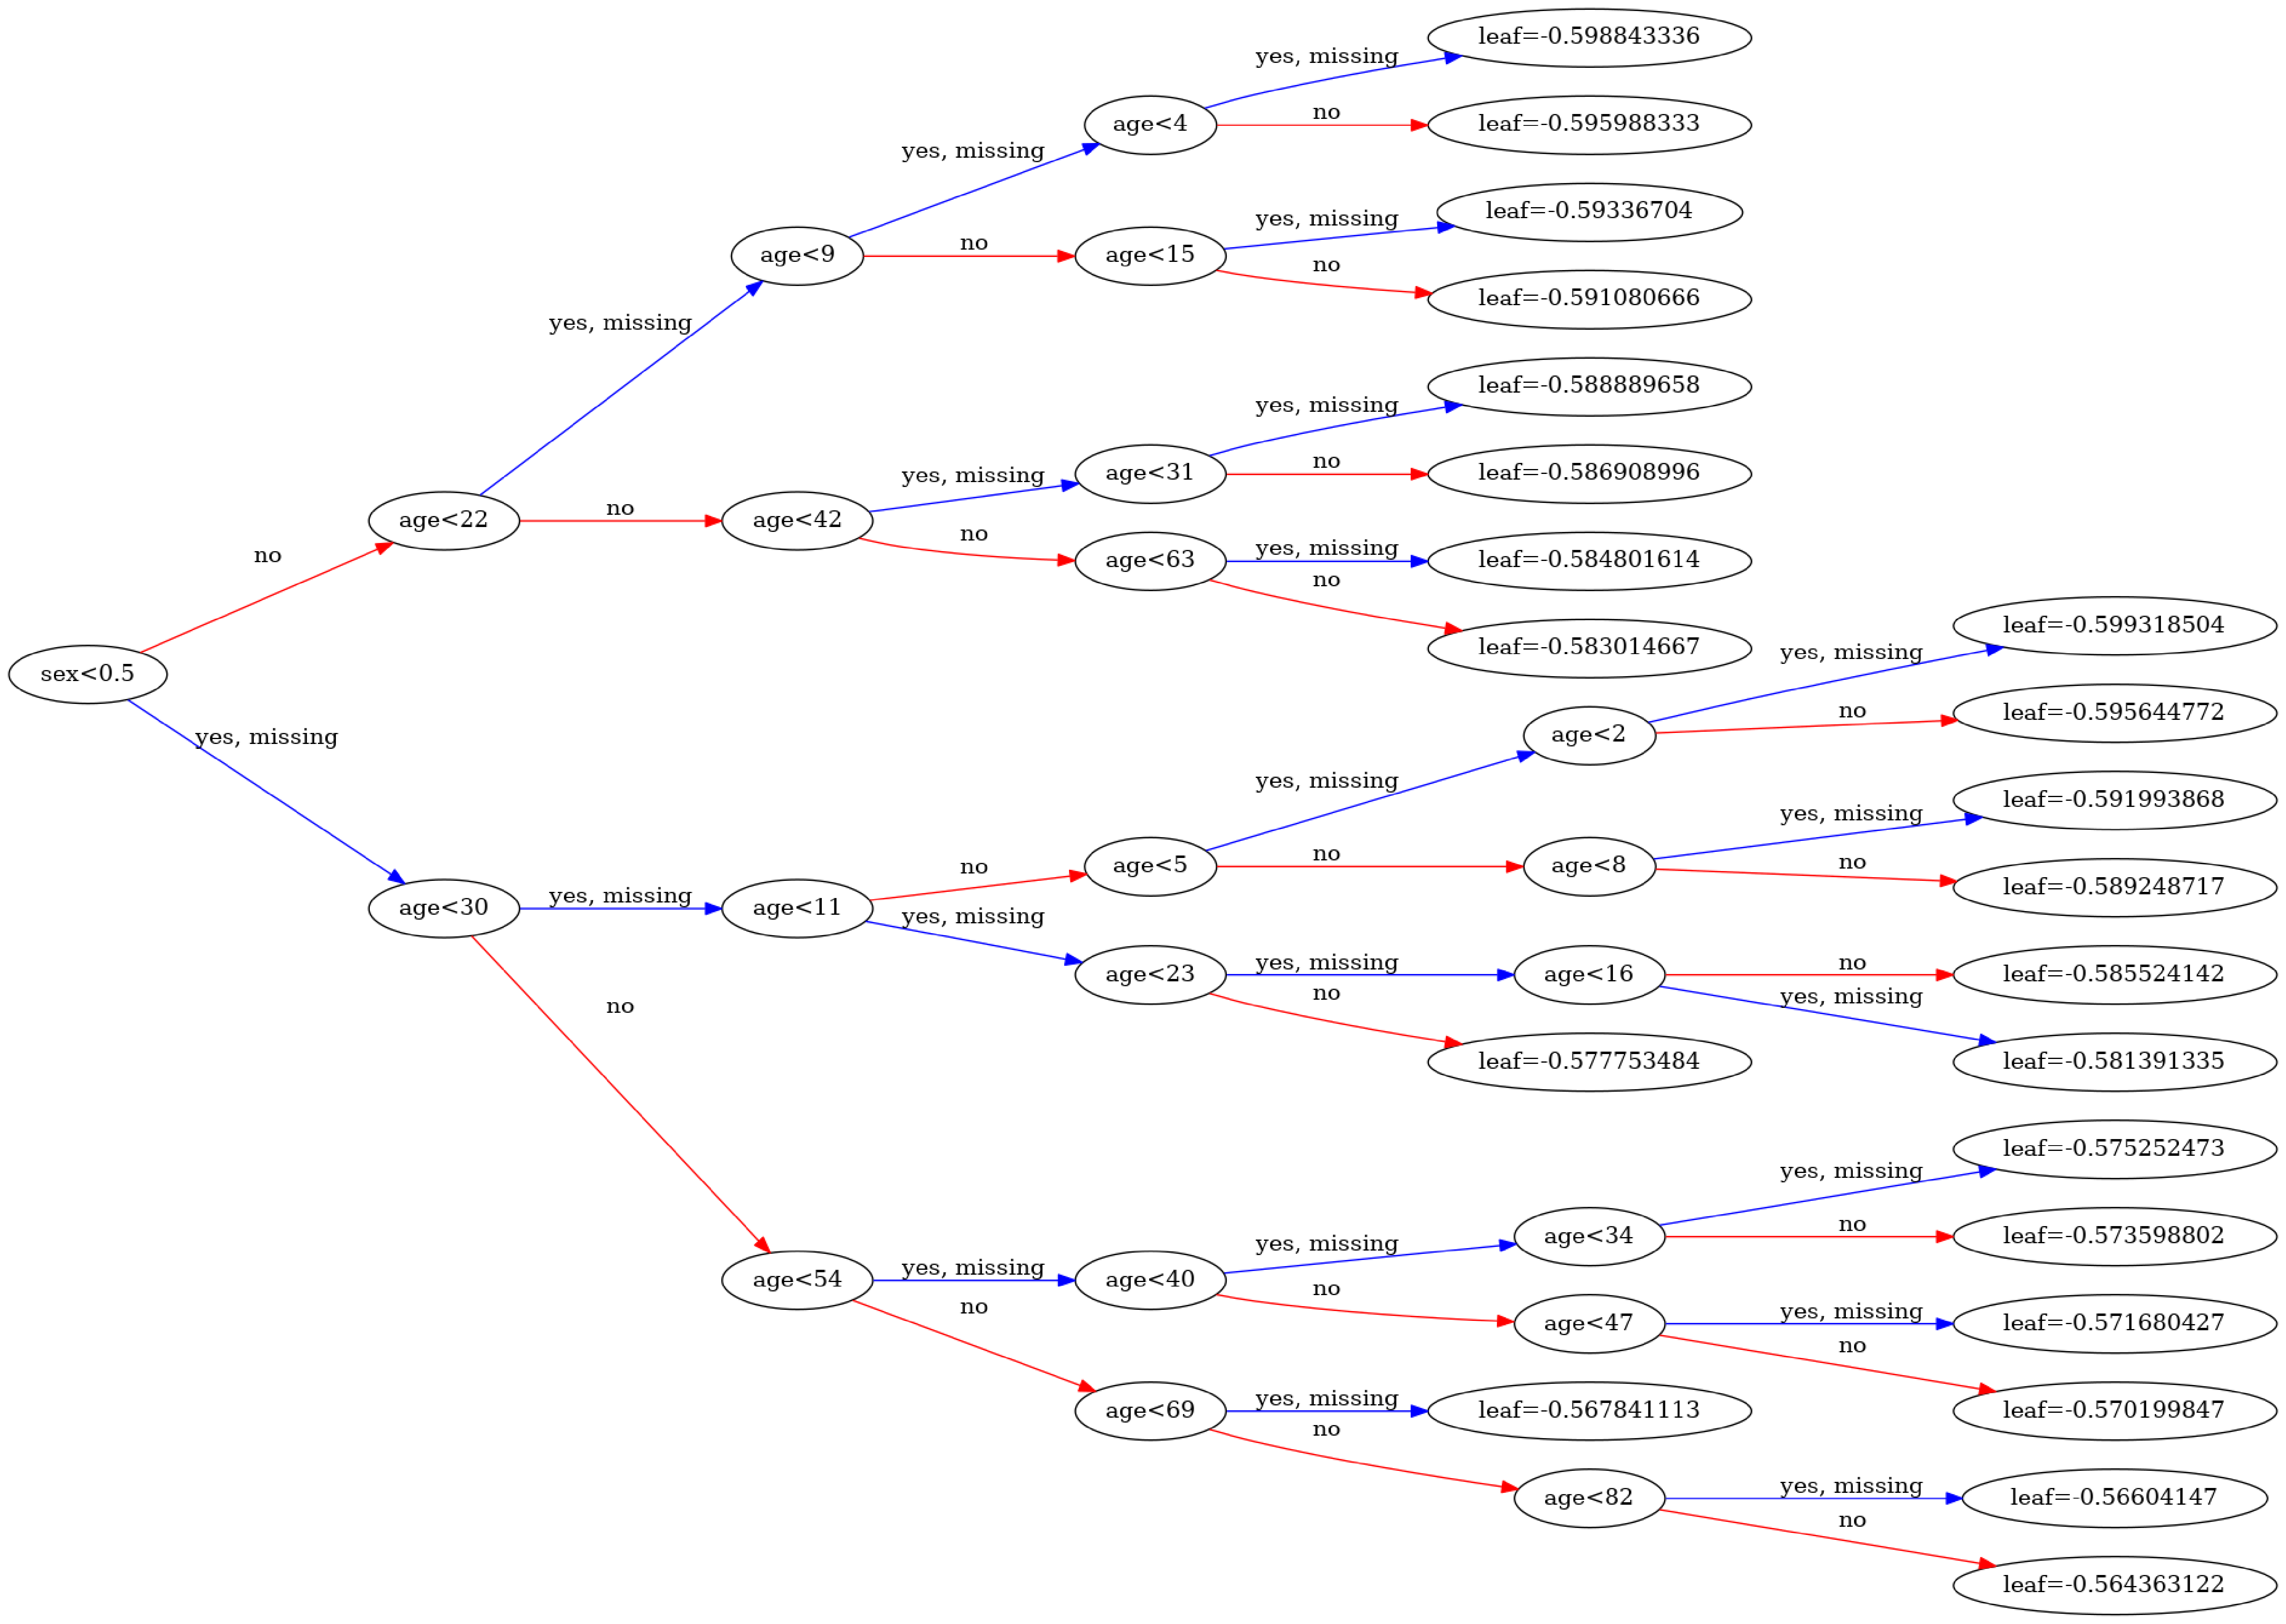

In [ ]:
xgb.plot_tree(model, num_trees=0, rankdir='LR')

# get current figure to set the size
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(100, 100)

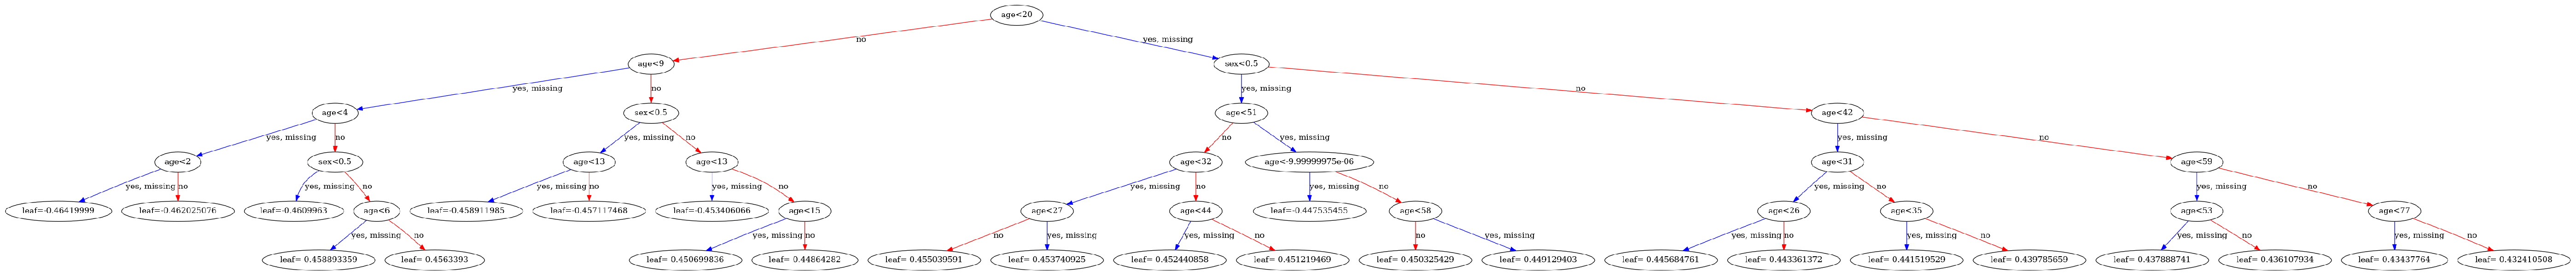

In [ ]:
xgb.plot_tree(model, num_trees=1, rankdir='TB')

# get current figure to set the size
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(100, 100)

## 執行預測

一旦對模型感到滿意，我們便可以對其進行預測。我們將對1100萬筆以上的數據進行預測。

In [ ]:
x_test.shape

(14619974, 4)

我們像以前一樣將*X*矩陣轉換為`DMatrix`，然後對每一筆資料進行預測。注意進行超過1100萬個預測所花費的時間。

In [ ]:
dtest = xgb.DMatrix(x_test)
%time y_pred = model.predict(dtest)

CPU times: user 83 ms, sys: 75.5 ms, total: 159 ms
Wall time: 158 ms


現在我們想看看這些預測有多好。一種常見的評估方法是計算receiver operating characteristic（ROC）曲線的曲線下面積（AUC）。

預測結果是一個`numpy`矩陣，因此我們將測試標籤轉換為對應，然後進行ROC曲線計算。

In [ ]:
y_test_cpu = cp.asnumpy(cp.array(y_test))
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test_cpu, y_pred)

最後，我們可以繪製曲線並計算AUC分數，以幫助我們評估真陽性和假陽性率之間的權衡。

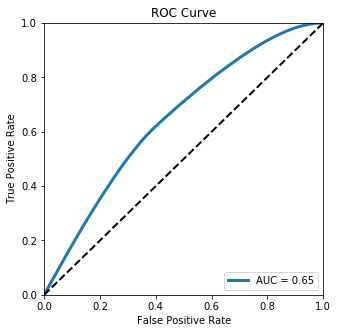

In [ ]:
auc_result = auc(false_pos_rate, true_pos_rate)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(false_pos_rate, true_pos_rate, lw=3,
        label='AUC = {:.2f}'.format(auc_result))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc='lower right');
plt.show()

<br>
<div align="center"><h2>請重啟 Kernel</h2></div>

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## 下一步

在下一個notebook中，您將通過cuGraph使用GPU加速的圖形分析功能，以按距離和時間來標識通往醫院的最短路徑。您還將可視覺化呈現您的發現結果。